# Demo and Model Analysis
This notebook is used to demonstrate the usage of LION and to analyze the model, component-by-component.

The below two cells are just copied from demo.py, to load a checkpoint and sample a point cloud.

In [1]:
# Import and load model
import os
import clip
import torch
from PIL import Image
from default_config import cfg as config
from models.lion import LION
from utils.vis_helper import plot_points
from huggingface_hub import hf_hub_download 

model_path = './lion_ckpt/snapshot' # path to model checkpoint
model_config = './lion_ckpt/cfg.yml' # path to model config

config.merge_from_file(model_config)
lion = LION(config)
lion.load_model(model_path)


Using /home/jw/.cache/torch_extensions/py38_cu111 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/jw/.cache/torch_extensions/py38_cu111/emd_ext/build.ninja...
Building extension module emd_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module emd_ext...
load emd_ext time: 0.066s
utils/utils.py: USE_COMET=1, USE_WB=0
Using /home/jw/.cache/torch_extensions/py38_cu111 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/jw/.cache/torch_extensions/py38_cu111/_pvcnn_backend/build.ninja...
Building extension module _pvcnn_backend...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module _pvcnn_backend...


2023-07-03 23:41:01.333 | INFO     | utils.model_helper:import_model:106 - import: models.shapelatent_modules.PointNetPlusEncoder
2023-07-03 23:41:01.337 | INFO     | models.shapelatent_modules:__init__:29 - [Encoder] zdim=128, out_sigma=True; force_att: 0
2023-07-03 23:41:01.337 | INFO     | utils.model_helper:import_model:106 - import: models.latent_points_ada.PointTransPVC
2023-07-03 23:41:01.337 | INFO     | models.latent_points_ada:__init__:38 - [Build Unet] extra_feature_channels=0, input_dim=3
2023-07-03 23:41:01.397 | INFO     | utils.model_helper:import_model:106 - import: models.latent_points_ada.LatentPointDecPVC
2023-07-03 23:41:01.398 | INFO     | models.latent_points_ada:__init__:241 - [Build Dec] point_dim=3, context_dim=1
2023-07-03 23:41:01.398 | INFO     | models.latent_points_ada:__init__:38 - [Build Unet] extra_feature_channels=1, input_dim=3
2023-07-03 23:41:01.458 | INFO     | models.vae_adain:__init__:50 - [Build Model] style_encoder: models.shapelatent_modules.P

INFO finish loading from ./lion_ckpt/snapshot


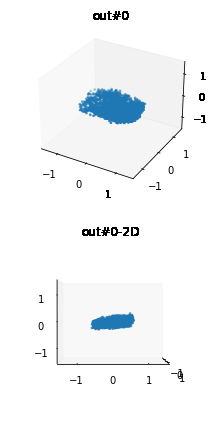

In [2]:
# Generate a sample
if config.clipforge.enable: # currently not used
    input_t = ["a swivel chair, five wheels"] 
    device_str = 'cuda'
    clip_model, clip_preprocess = clip.load(
                        config.clipforge.clip_model, device=device_str)    
    text = clip.tokenize(input_t).to(device_str)
    clip_feat = []
    clip_feat.append(clip_model.encode_text(text).float())
    clip_feat = torch.cat(clip_feat, dim=0)
    print('clip_feat', clip_feat.shape)
else:
    clip_feat = None
output_latent = lion.sample(1 if clip_feat is None else clip_feat.shape[0], clip_feat=clip_feat)
pts = output_latent['points']
img_name = "/tmp/tmp.png"
plot_points(pts, output_name=img_name)
img = Image.open(img_name)
display(img)

# VAE: Global Encoder
The encoder takes in a point cloud and outputs a latent vector. The input point cloud is first passed through the global encoder (`vae.style_encoder`) to get a global feature vector, in this paper referred to as the **global prior**.

In [3]:
print(lion.vae.style_encoder)

PointNetPlusEncoder(
  (mlp): Linear(in_features=64, out_features=256, bias=True)
  (layers): ModuleList(
    (0): Sequential(
      (0): PVConv(
        (voxelization): Voxelization(resolution=32, normalized eps = 0)
        (voxel_layers): Sequential(
          (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm(8, 32, eps=1e-05, affine=True)
          (2): Swish()
          (3): Dropout(p=0.1, inplace=False)
          (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (5): GroupNorm(8, 32, eps=1e-05, affine=True)
          (6): SE(32, 32)
        )
        (point_features): SharedMLP(
          (layers): Sequential(
            (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
            (1): GroupNorm(8, 32, eps=1e-05, affine=True)
            (2): Swish()
          )
        )
      )
      (1): PVConv(
        (voxelization): Voxelization(resolution=32, normalized eps = 0)
        (voxel_l

In [4]:
# random sample point cloud
B, N = 1, 2048 # batch size, number of points
input_pc = torch.randn(B, N, 3).cuda() # B, N, 3 (x, y, z)

output_latent = lion.vae.style_encoder(input_pc)
mu, sigma = output_latent['mu_1d'], output_latent['sigma_1d']

print(f"Input Point Cloud: {input_pc.shape}")
print(f"Output Latent: mu={mu.shape}, sigma={sigma.shape}")

Input Point Cloud: torch.Size([1, 2048, 3])
Output Latent: mu=torch.Size([1, 128]), sigma=torch.Size([1, 128])


### The architecture of the global encoder (`PointNetPlusEncoder`)
The global encoder `PointNetPlusEncoder` consists of `PVConv` and ... (TODO) layers.


#### PVConv (PVCNN)
From the [PVCNN architecture](https://pvcnn.mit.edu/). One PVConv layer is conceptually similar to a convolutional layer, but applied to a point cloud. It takes an input point cloud of dim (B, 3, N) with a per-point feature vector of dim (B, C, N) and outputs a per-point feature vector of dim (B, C', N).

The feature vector is initially just a copy of the point cloud (i.e. C=[xyz]), then the number of channels gradually gets increased, just like a CNN.

In [5]:
pvconv = lion.vae.style_encoder.layers[0][0]
print(pvconv)

features = coords = input_pc.transpose(1, 2) # B, 3, N
inputs = (features, coords, None) # (features, coords, time_embedding)

# pvconv turns the 3-channel features into 32-channel features
# coords_input is just the same as coords
fused_features, coords_input, time_emb = pvconv(inputs)

print(f"fused_features: {fused_features.shape}")
print(f"coords_input: {coords_input.shape}, {coords is coords_input}")

PVConv(
  (voxelization): Voxelization(resolution=32, normalized eps = 0)
  (voxel_layers): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): GroupNorm(8, 32, eps=1e-05, affine=True)
    (2): Swish()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): GroupNorm(8, 32, eps=1e-05, affine=True)
    (6): SE(32, 32)
  )
  (point_features): SharedMLP(
    (layers): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): GroupNorm(8, 32, eps=1e-05, affine=True)
      (2): Swish()
    )
  )
)
fused_features: torch.Size([1, 32, 2048])
coords_input: torch.Size([1, 3, 2048]), True


####

# Global Prior
The global prior is a latent vector of size (128,) that encodes information about the entire shape. When given an input point cloud (for either reconstruction or completion), it is produced by the encoder of the VAE. On the other hand, when doing generation, it is sampled from a standard normal distribution, as in a standard VAE. However, in order to make the global prior more informative, we use a technique called **Latent Diffusion**, which is done by the `global_prior` module.
The global prior is then used to condition the decoder of the VAE to produce the output point cloud.
> Note: In this case, the shape of the global prior latent vector is actually (128, 1, 1), as you can see below, in order to use `Conv2D` with kernel size (1, 1) and stride 1 as a "hacky way" to learn a multiplicative scalar factor for each of the 128 channels of the input latent vector. I.e. the extra 1, 1 are the dummy width and heights of the latent vector.  
> `TODO: so why not just use a Linear layer?`

In [6]:
global_prior, local_prior = lion.priors
global_latent_shape, local_latent_shape = lion.vae.latent_shape()
print('global_latent_shape', global_latent_shape)
print('local_latent_shape', local_latent_shape)
# print(global_prior)

N = 3 # num samples

x = torch.randn(size=(N, *global_latent_shape)).cuda()
t = torch.ones(N, dtype=torch.int64).cuda()

print(global_prior)

print('output shape', global_prior(x, t.float()).shape)

global_latent_shape [128, 1, 1]
local_latent_shape [8192, 1, 1]
PriorSEDrop(
  (act): SiLU()
  (temb_fun): PositionalEmbedding()
  (temb_layer): Sequential(
    (0): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1))
  )
  (input_layer): Conv2d(128, 2048, kernel_size=(1, 1), stride=(1, 1))
  (output_layer): Conv2d(2048, 128, kernel_size=(1, 1), stride=(1, 1))
  (all_modules): ModuleList(
    (0): ResBlockSE_withdropout(2048, 2048, drop=0.300000)
    (1): ResBlockSE_withdropout(2048, 2048, drop=0.300000)
    (2): ResBlockSE_withdropout(2048, 2048, drop=0.300000)
    (3): ResBlockSE_withdropout(2048, 2048, drop=0.300000)
    (4): ResBlockSE_withdropout(2048, 2048, drop=0.300000)
    (5): ResBlockSE_withdropout(2048, 2048, drop=0.300000)
    (6): ResBlockSE_withdropout(2048, 2048, drop=0.300000)
    (7): ResBlockSE_withdropout(2048, 2048, drop=0.300000)
  )
)
output shape torch.Size([3, 128, 1, 1])
